## Imports standard

In [37]:

import os
import sys
import time
import json
import subprocess
import random
import pandas as pd
import numpy as np
import cv2
import urllib.request
import tarfile
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML, display

## Config centralisée

In [38]:
# Chemins et URLs pour les ressources du projet
train_dir        = "../data/DL_data/train"
val_dir          = "../data/DL_data/valid"

train_ann        = f"{train_dir}/_annotations.csv"
val_ann          = f"{val_dir}/_annotations.csv"


pretrain_ckpt    = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"

output_dir       = "../models/dl_model/outputs/ssd_mnv2_320"
label_map        = f"{output_dir}/label_map.pbtxt"
tfrecord_train   = f"{output_dir}/train.record"
tfrecord_val     = f"{output_dir}/val.record"

tracking         = "tensorboard"
tensorboard_url  = "http://localhost:6006"

chemin_research = os.path.abspath("tensorflow_models/research")
chemin_slim = os.path.abspath("tensorflow_models/research/slim")



# Configuration centralisee de tous les hyperparametres
#test effectuer j'ai modifier 

# ===== VARIABLES CENTRALISEES DU DEBUT =====
taille_image = 320                           # cote carre des images pour le checkpoint
base_lr = 0.01                               # learning rate de depart
num_steps = 120000                            # nombre total d'etapes (30000 = 40 epochs environ)
warmup_steps_ratio = 0.05                    # ratio pour le warmup (5% des steps)

# ===== HYPERPARAMETRES D'ENTRAINEMENT =====
learning_rate_base = 0.008                   # vitesse d'apprentissage de base (plus haut = plus rapide mais moins stable)
total_steps = num_steps                      # nombre total d'etapes d'entrainement (plus = meilleur mais plus long)
batch_size = 16                              # nombre d'images par batch (plus haut = plus rapide mais plus de memoire)
warmup_learning_rate = 0.0014                # vitesse d'apprentissage pendant le warmup (debut d'entrainement)
warmup_steps = 2000                          # nombre d'etapes de warmup (stabilise le debut)
momentum_value = 0.6                         # momentum de l'optimisateur (aide a converger plus vite)

# ===== HYPERPARAMETRES DU MODELE =====
num_classes = 2                              # nombre de classes (Healthy, Contaminated)
image_height = 320                           # hauteur des images d'entree
image_width = 320                            # largeur des images d'entree
depth_multiplier = 1.25                       # facteur de largeur du reseau (1.0 = taille normale)

# ===== HYPERPARAMETRES DE REGULARISATION =====
l2_weight = 0.00005                          # regularisation L2 (evite le surapprentissage)
use_dropout = False                          # activer ou non le dropout (le model ssd a deja un dropout interne a activer en cas de loss qui augmente trop)
dropout_probability = 0.7                    # probabilite de dropout (si active)

# ===== HYPERPARAMETRES DE LOSS =====
focal_loss_gamma = 3.0                       # gamma de la focal loss (se concentre sur les exemples difficiles)
focal_loss_alpha = 0.5                      # alpha de la focal loss (equilibre les classes)
smooth_l1_delta = 1.0                        # parametre de la smooth L1 loss pour les boites
classification_weight = 1.0                  # poids de la loss de classification
localization_weight = 1.0                    # poids de la loss de localisation

# ===== HYPERPARAMETRES DE POST-PROCESSING =====
score_threshold = 0.50                       # seuil de confiance minimal pour les detections
iou_threshold = 0.60                         # seuil IoU pour supprimer les detections qui se chevauchent
max_detections_per_class = 5               # nombre max de detections par classe
max_total_detections = 10                   # nombre max total de detections

# ===== SYNCHRONISATION AVEC LES VARIABLES EXISTANTES =====
# Synchroniser avec les variables du debut du notebook
num_steps = total_steps
taille_image = image_height  # Garder coherence

print("Parametres charges avec les valeurs actuelles du fichier config")
print(f"Total steps: {total_steps:,}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate_base}")
print(f"Image size: {image_height}x{image_width}")

Parametres charges avec les valeurs actuelles du fichier config
Total steps: 120,000
Batch size: 16
Learning rate: 0.008
Image size: 320x320


## Imports bibliotheques

In [39]:
if chemin_research not in sys.path:
    sys.path.insert(0, chemin_research)
if chemin_slim not in sys.path:
    sys.path.insert(0, chemin_slim)

# Imports Object Detection API
try:
    from object_detection.utils import config_util
    from object_detection.builders import model_builder
    print("Object Detection API importé avec succès")
except ImportError as e:
    print(f"Erreur import Object Detection API: {e}")

print(f"TensorFlow: {tf.__version__}")
print(f"Python: {sys.version[:5]}")
print(f"PYTHONPATH configuré: {chemin_research}")

Object Detection API importé avec succès
TensorFlow: 2.15.0
Python: 3.10.
PYTHONPATH configuré: /home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research


## Test configuration GPU

In [40]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU détecté: {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"Erreur GPU: {e}")
else:
    print("Aucun GPU détecté")

GPU détecté: 1 GPU(s)


## Traitement sur les Données

ANALYSE DES DONNEES - 
Détection Contamination
Chargement des donnees...
Train: 16787 annotations
Validation: 1006 annotations
Total images: 9929
Total annotations: 17793

Distribution des classes:
TRAIN:
  Healthy: 9544 (56.9%)
  Contaminated: 7243 (43.1%)
VALIDATION:
  Healthy: 544 (54.1%)
  Contaminated: 462 (45.9%)
DATASET GLOBAL:
Images totales: 9929
Annotations totales: 17793
Repartition: 94.3% train / 5.7% validation

CLASSES:
  Ratio Healthy/Contaminated: 1.32
  STATUS: Classes equilibrees

BOUNDING BOXES:
Taille moyenne train: 457x482 px
Taille moyenne validation: 501x560 px
Aire moyenne train: 268704 px²
Aire moyenne validation: 335050 px²

QUALITE DU DATASET:
Repartition train/val: BONNE

RECOMMANDATIONS:
Focal Loss Alpha: 0.5 (adapte au desequilibre)
Batch Size: 16 (optimise pour GPU)
Learning Rate: 0.008 (stable)
Total Steps: 120,000 (suffisant pour convergence)


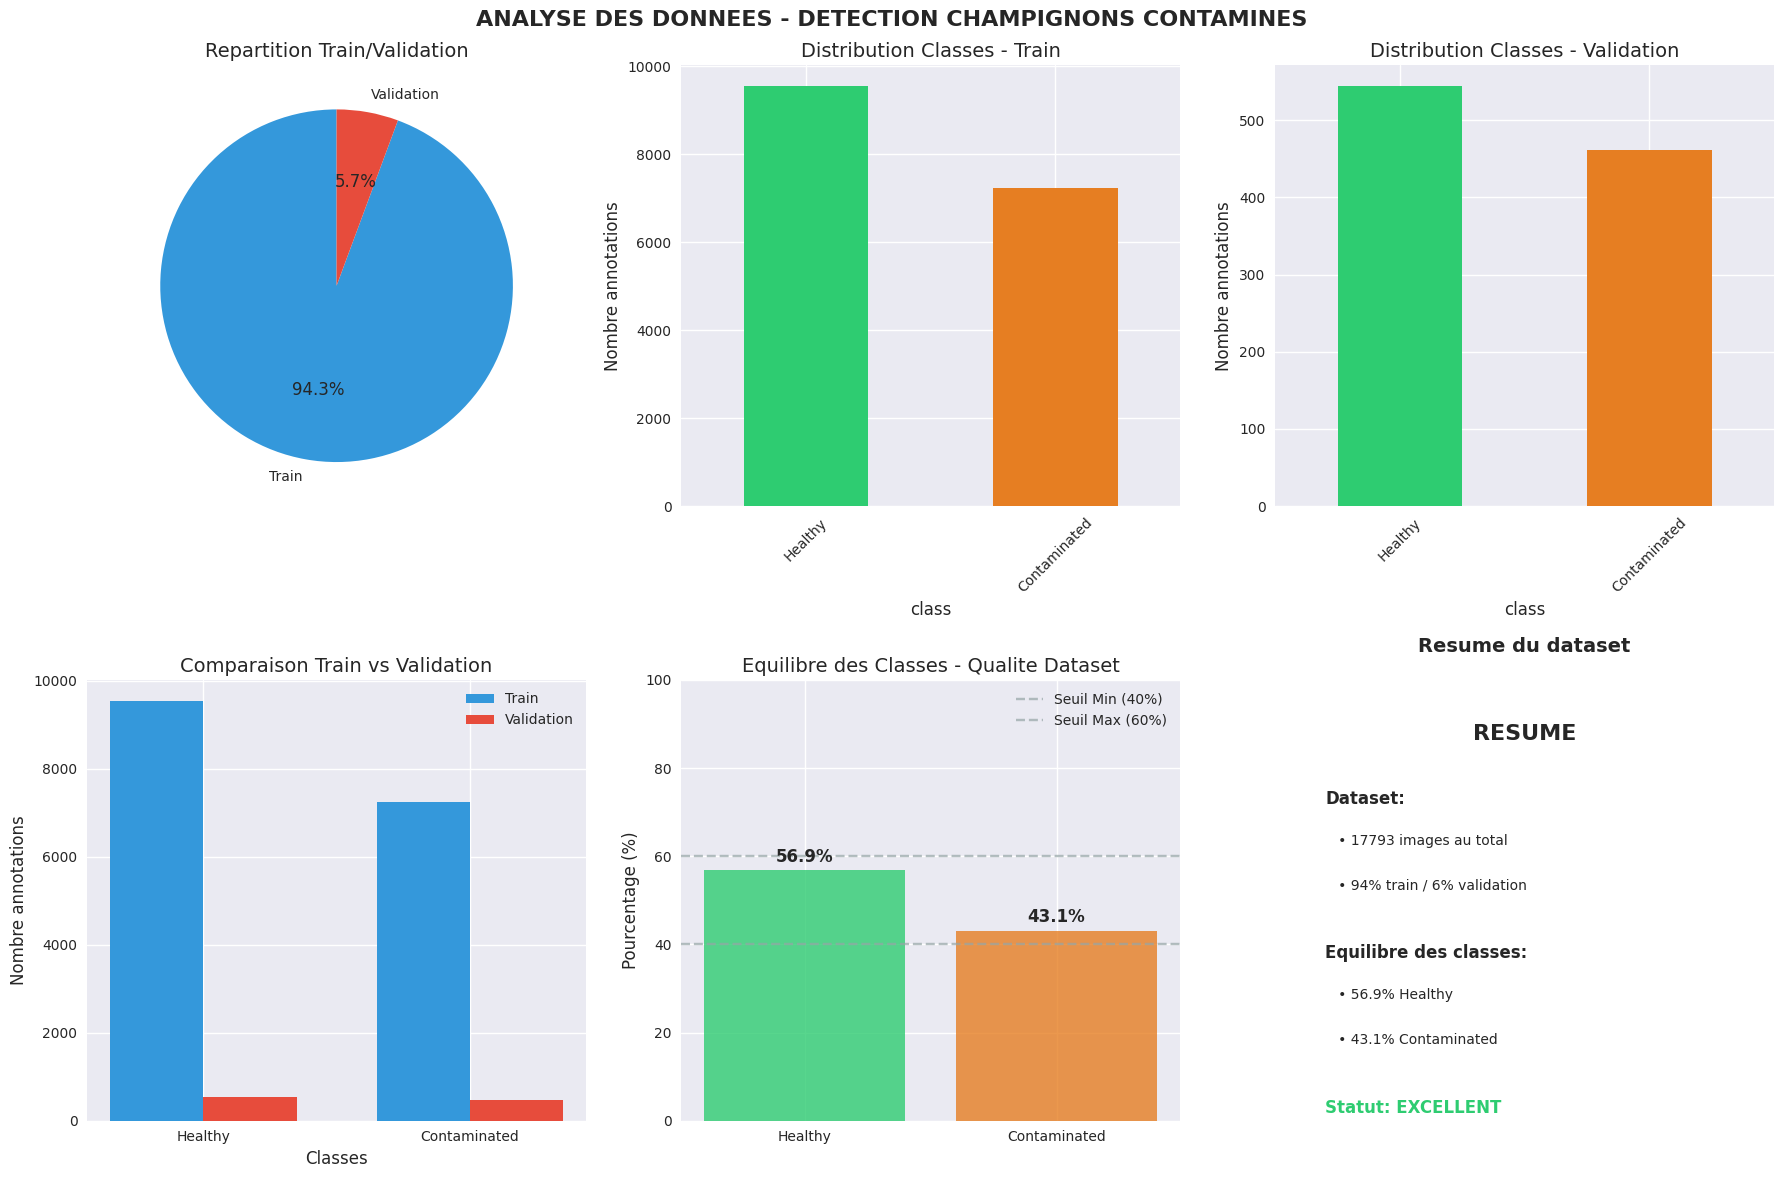

In [41]:
# Charger les donnees
print("ANALYSE DES DONNEES - \nDétection Contamination")


# Verifier existence fichiers
if not os.path.exists(train_ann):
    print(f"ERREUR: Fichier train manquant: {train_ann}")
    exit()

if not os.path.exists(val_ann):
    print(f"ERREUR: Fichier validation manquant: {val_ann}")
    exit()

# Charger les donnees
print("Chargement des donnees...")
train_df = pd.read_csv(train_ann)
val_df = pd.read_csv(val_ann)

print(f"Train: {len(train_df)} annotations")
print(f"Validation: {len(val_df)} annotations")

# Calculer les statistiques
train_images = train_df['filename'].nunique()
val_images = val_df['filename'].nunique()
total_annotations = len(train_df) + len(val_df)
total_images = train_images + val_images

print(f"Total images: {total_images}")
print(f"Total annotations: {total_annotations}")

# Calcul des bounding boxes
train_df['bbox_width'] = train_df['xmax'] - train_df['xmin']
train_df['bbox_height'] = train_df['ymax'] - train_df['ymin']
train_df['bbox_area'] = train_df['bbox_width'] * train_df['bbox_height']

val_df['bbox_width'] = val_df['xmax'] - val_df['xmin']
val_df['bbox_height'] = val_df['ymax'] - val_df['ymin']
val_df['bbox_area'] = val_df['bbox_width'] * val_df['bbox_height']

train_classes = train_df['class'].value_counts()
val_classes = val_df['class'].value_counts()

print("\nDistribution des classes:")
print("TRAIN:")
for classe, count in train_classes.items():
    pct = count / len(train_df) * 100
    print(f"  {classe}: {count} ({pct:.1f}%)")

print("VALIDATION:")
for classe, count in val_classes.items():
    pct = count / len(val_df) * 100
    print(f"  {classe}: {count} ({pct:.1f}%)")

# Configuration matplotlib
import matplotlib
matplotlib.use('Agg')  
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Alternative: utiliser le backend inline pour Jupyter
%matplotlib inline

# Creer figure avec sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ANALYSE DES DONNEES - DETECTION CHAMPIGNONS CONTAMINES', fontsize=16, fontweight='bold')

# 1. Repartition Train/Validation
ax1 = axes[0, 0]
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']
colors = ['#3498db', '#e74c3c']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Repartition Train/Validation')

# 2. Distribution des classes - Train
ax2 = axes[0, 1]
train_classes.plot(kind='bar', ax=ax2, color=['#2ecc71', '#e67e22'])
ax2.set_title('Distribution Classes - Train')
ax2.set_ylabel('Nombre annotations')
ax2.tick_params(axis='x', rotation=45)

# 3. Distribution des classes - Validation
ax3 = axes[0, 2]
val_classes.plot(kind='bar', ax=ax3, color=['#2ecc71', '#e67e22'])
ax3.set_title('Distribution Classes - Validation')
ax3.set_ylabel('Nombre annotations')
ax3.tick_params(axis='x', rotation=45)

# 4. Comparaison Train vs Validation
ax4 = axes[1, 0]
classes = list(train_classes.index)
train_counts = [train_classes[c] for c in classes]
val_counts = [val_classes[c] if c in val_classes else 0 for c in classes]

x = np.arange(len(classes))
width = 0.35

ax4.bar(x - width/2, train_counts, width, label='Train', color='#3498db')
ax4.bar(x + width/2, val_counts, width, label='Validation', color='#e74c3c')
ax4.set_xlabel('Classes')
ax4.set_ylabel('Nombre annotations')
ax4.set_title('Comparaison Train vs Validation')
ax4.set_xticks(x)
ax4.set_xticklabels(classes)
ax4.legend()

# 5. Analyse de la qualite du dataset
ax5 = axes[1, 1]
# Calcul du ratio d'equilibre des classes
healthy_ratio = train_classes.get('Healthy', 0) / len(train_df) * 100
contaminated_ratio = train_classes.get('Contaminated', 0) / len(train_df) * 100

# Graphique en barres avec seuils de qualite
categories = ['Healthy', 'Contaminated', 'Seuil Ideal Min', 'Seuil Ideal Max']
values = [healthy_ratio, contaminated_ratio, 40, 60]
colors = ['#2ecc71', '#e67e22', '#95a5a6', '#95a5a6']

bars = ax5.bar(categories[:2], values[:2], color=colors[:2], alpha=0.8)
ax5.axhline(y=40, color='#95a5a6', linestyle='--', alpha=0.7, label='Seuil Min (40%)')
ax5.axhline(y=60, color='#95a5a6', linestyle='--', alpha=0.7, label='Seuil Max (60%)')
ax5.set_ylabel('Pourcentage (%)')
ax5.set_title('Equilibre des Classes - Qualite Dataset')
ax5.legend()
ax5.set_ylim(0, 100)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 6. Resume executif pour le jury
ax6 = axes[1, 2]
ax6.axis('off')  # Pas de graphique, juste du texte

# Calculer les stats importantes
total_train = len(train_df)
total_val = len(val_df)
healthy_train_pct = train_classes.get('Healthy', 0) / total_train * 100
contaminated_train_pct = train_classes.get('Contaminated', 0) / total_train * 100
train_val_ratio = total_train / (total_train + total_val) * 100

# Statut du dataset
if abs(healthy_train_pct - 50) < 10:
    equilibre_status = "EXCELLENT"
    equilibre_color = '#2ecc71'
elif abs(healthy_train_pct - 50) < 20:
    equilibre_status = "BON"
    equilibre_color = '#f39c12'
else:
    equilibre_status = "A AMELIORER"
    equilibre_color = '#e74c3c'

# Afficher le resume
ax6.text(0.5, 0.9, 'RESUME', ha='center', va='top', fontsize=16, fontweight='bold', transform=ax6.transAxes)

ax6.text(0.1, 0.75, f'Dataset:', ha='left', va='top', fontsize=12, fontweight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.65, f'   • {total_train + total_val} images au total', ha='left', va='top', fontsize=10, transform=ax6.transAxes)
ax6.text(0.1, 0.55, f'   • {train_val_ratio:.0f}% train / {100-train_val_ratio:.0f}% validation', ha='left', va='top', fontsize=10, transform=ax6.transAxes)

ax6.text(0.1, 0.4, f'Equilibre des classes:', ha='left', va='top', fontsize=12, fontweight='bold', transform=ax6.transAxes)
ax6.text(0.1, 0.3, f'   • {healthy_train_pct:.1f}% Healthy', ha='left', va='top', fontsize=10, transform=ax6.transAxes)
ax6.text(0.1, 0.2, f'   • {contaminated_train_pct:.1f}% Contaminated', ha='left', va='top', fontsize=10, transform=ax6.transAxes)

ax6.text(0.1, 0.05, f'Statut: {equilibre_status}', ha='left', va='top', fontsize=12, fontweight='bold', 
         color=equilibre_color, transform=ax6.transAxes)

ax6.set_title('Resume du dataset', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

print(f"DATASET GLOBAL:")
print(f"Images totales: {total_images}")
print(f"Annotations totales: {total_annotations}")
print(f"Repartition: {len(train_df)/(len(train_df)+len(val_df))*100:.1f}% train / {len(val_df)/(len(train_df)+len(val_df))*100:.1f}% validation")

print(f"\nCLASSES:")
if 'Healthy' in train_classes and 'Contaminated' in train_classes:
    ratio = train_classes['Healthy'] / train_classes['Contaminated']
    print(f"  Ratio Healthy/Contaminated: {ratio:.2f}")
    if ratio > 2 or ratio < 0.5:
        print(f"  STATUS: Desequilibre detecte - Focal Loss necessaire")
    else:
        print(f"  STATUS: Classes equilibrees")

print(f"\nBOUNDING BOXES:")
print(f"Taille moyenne train: {train_df['bbox_width'].mean():.0f}x{train_df['bbox_height'].mean():.0f} px")
print(f"Taille moyenne validation: {val_df['bbox_width'].mean():.0f}x{val_df['bbox_height'].mean():.0f} px")
print(f"Aire moyenne train: {train_df['bbox_area'].mean():.0f} px²")
print(f"Aire moyenne validation: {val_df['bbox_area'].mean():.0f} px²")

print(f"\nQUALITE DU DATASET:")
train_val_diff = abs(len(train_df)/(len(train_df)+len(val_df)) - 0.8)
if train_val_diff < 0.1:
    print(f"Repartition train/val: EXCELLENTE")
elif train_val_diff < 0.2:
    print(f"Repartition train/val: BONNE")
else:
    print(f"Repartition train/val: A AMELIORER")

print(f"\nRECOMMANDATIONS:")
print(f"Focal Loss Alpha: {focal_loss_alpha} (adapte au desequilibre)")
print(f"Batch Size: {batch_size} (optimise pour GPU)")
print(f"Learning Rate: {learning_rate_base} (stable)")
print(f"Total Steps: {total_steps:,} (suffisant pour convergence)")



## Création du label map

Ce fichier fait le lien entre les IDs numériques du modèle et les noms de classes compréhensibles par l'humain. Il est indispensable pour que tout le pipeline fonctionne correctement !

In [42]:

label_map_content = """item {
  id: 1
  name: 'Healthy'
}
item {
  id: 2
  name: 'Contaminated'
}
"""

with open(label_map, 'w') as f:
    f.write(label_map_content)

print(f"Label map créé: {label_map}")
print("Classes:")
print("1: Healthy")
print("2: Contaminated")

Label map créé: ../models/dl_model/outputs/ssd_mnv2_320/label_map.pbtxt
Classes:
1: Healthy
2: Contaminated


In [43]:
def creer_tf_exemple(row, img_dir):
    """Convertit une ligne CSV en format tf.train.Example"""
    
    # Chemins des fichiers
    img_path = os.path.join(img_dir, row['filename'])
    
    # Vérification de l'existence de l'image
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image introuvable: {img_path}")
    
    # Lecture de l'image
    with tf.io.gfile.GFile(img_path, 'rb') as fid:
        encoded_image = fid.read()
    
    # Obtenir les dimensions de l'image
    image = tf.image.decode_image(encoded_image)
    height, width = image.shape[:2]
    
    # Validation des dimensions
    if height != row['height'] or width != row['width']:
        print(f"Dimensions incohérentes pour {row['filename']}: CSV({row['width']}x{row['height']}) vs Image({width}x{height})")
    
    # Normalisation des coordonnées (0-1)
    xmin_norm = row['xmin'] / width
    xmax_norm = row['xmax'] / width
    ymin_norm = row['ymin'] / height
    ymax_norm = row['ymax'] / height
    
    # Mapping des classes
    class_mapping = {'Healthy': 1, 'Contaminated': 2}
    class_id = class_mapping.get(row['class'])
    if class_id is None:
        raise ValueError(f"Classe inconnue: {row['class']}")
    
    # Création de l'exemple TF
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['filename'].encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[b'jpeg'])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=[xmin_norm])),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=[xmax_norm])),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=[ymin_norm])),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=[ymax_norm])),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[row['class'].encode('utf8')])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=[class_id])),
    }))
    
    return tf_example

def convert_csv_to_tfrecord(csv_path, img_dir, output_path):
    """Convertit un CSV en TFRecord"""
    
    print(f"Lecture du CSV: {csv_path}")
    
    # Lecture du CSV
    df = pd.read_csv(csv_path)

## chargement du fichier de config du pipeline
Ce fichier contient les paramètres du modèle, les chemins d'accès aux données, etc.

In [44]:



# Chemin vers le fichier de configuration qui fonctionne
pipeline_working_config = "../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config"

print(f"Chargement de la configuration du pipeline depuis: {pipeline_working_config}")

# Vérifier que le fichier existe
if not os.path.exists(pipeline_working_config):
    raise FileNotFoundError(f"Fichier de configuration non trouvé: {pipeline_working_config}")

# Lire le contenu du fichier
with open(pipeline_working_config, 'r') as f:
    pipeline_config_content = f.read()

print("Configuration du pipeline chargée avec succès!")


Chargement de la configuration du pipeline depuis: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
Configuration du pipeline chargée avec succès!


In [45]:
# Utiliser directement le fichier de configuration existant
pipeline_cfg = pipeline_working_config
print(f"Fichier de configuration: {pipeline_cfg}")

# Afficher les paramètres d'entraînement
print(f"Paramètres d'entraînement:")
print(f"   Architecture: SSD MobileNet V2 (320x320)")
print(f"   Batch size: {batch_size}")
print(f"   Steps: {num_steps:,}")
print(f"   Learning rate: {base_lr} (cosine decay)")
print(f"   Warmup steps: {warmup_steps}")
print(f"   Image size: {taille_image}x{taille_image}")
print(f"   Répertoire de sortie: {output_dir}")

print("\nConfiguration prête pour l'entraînement!")

Fichier de configuration: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
Paramètres d'entraînement:
   Architecture: SSD MobileNet V2 (320x320)
   Batch size: 16
   Steps: 120,000
   Learning rate: 0.01 (cosine decay)
   Warmup steps: 2000
   Image size: 320x320
   Répertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320

Configuration prête pour l'entraînement!


## tableau de bord pour surveiller l'entraînement !

In [46]:
print("Démarrage de TensorBoard...")

# Arrêter toute instance existante
try:
    subprocess.run(["pkill", "-f", "tensorboard"], capture_output=True)
    time.sleep(1)
    print("   Instances précédentes arrêtées")
except:
    pass

# Chemin Python correct pour l'environnement virtuel
python_path = "/home/sarsator/projets/gaia_vision/.venv/bin/python"

# Lancer TensorBoard avec le bon interpréteur
tensorboard_cmd = f"{python_path} -m tensorboard.main --logdir={output_dir} --port=6006 --host=0.0.0.0"

print(f"Lancement de TensorBoard...")
print(f"   Commande: {tensorboard_cmd}")

# Utiliser nohup pour lancer en arrière-plan sans bloquer
launch_cmd = f"nohup {tensorboard_cmd} > tensorboard.log 2>&1 &"
os.system(launch_cmd)

time.sleep(3)  # Attendre que TensorBoard démarre

# Vérifier si TensorBoard fonctionne
try:
    result = subprocess.run(["curl", "-s", tensorboard_url], 
                           capture_output=True, timeout=5)
    if result.returncode == 0:
        print("TensorBoard démarré avec succès!")
                
        # Afficher le lien cliquable dans Jupyter
        display(HTML(f'<a href="{tensorboard_url}" target="_blank">Ouvrir TensorBoard dans un nouvel onglet</a>'))
        
    else:
        print("TensorBoard en cours de démarrage...")
        print(f"Essayez: {tensorboard_url} dans quelques secondes")
except:
    print("TensorBoard en cours de démarrage...")
    print(f"Essayez: {tensorboard_url} dans quelques secondes")


Démarrage de TensorBoard...
   Instances précédentes arrêtées
Lancement de TensorBoard...
   Commande: /home/sarsator/projets/gaia_vision/.venv/bin/python -m tensorboard.main --logdir=../models/dl_model/outputs/ssd_mnv2_320 --port=6006 --host=0.0.0.0
   Instances précédentes arrêtées
Lancement de TensorBoard...
   Commande: /home/sarsator/projets/gaia_vision/.venv/bin/python -m tensorboard.main --logdir=../models/dl_model/outputs/ssd_mnv2_320 --port=6006 --host=0.0.0.0
TensorBoard démarré avec succès!
TensorBoard démarré avec succès!


## diagnostique et vérification avant entraînement

In [47]:
# 1. Vérification des fichiers requis
print("Vérification des fichiers requis:")
files_to_check = [
    ("Label map", label_map),
    ("TFRecord train", tfrecord_train), 
    ("TFRecord validation", tfrecord_val),
    ("Pipeline config", pipeline_cfg),
]

all_files_exist = True
for name, path in files_to_check:
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024*1024)  # Size in MB
        print(f"✅ {name}: {path} ({size:.1f} MB)")
    else:
        print(f"❌ MANQUANT {name}: {path}")
        all_files_exist = False

# 2. Vérification du répertoire de sortie
print(f"\nStructure du répertoire de sortie ({output_dir}):")
if os.path.exists(output_dir):
    for item in os.listdir(output_dir):
        item_path = os.path.join(output_dir, item)
        if os.path.isdir(item_path):
            print(f"📁 Dossier: {item}/")
        else:
            size = os.path.getsize(item_path) / (1024*1024)
            print(f"   📄 Fichier: {item} ({size:.1f} MB)")
else:
    print(f"   ❌ ERREUR: Le répertoire {output_dir} n'existe pas")
    all_files_exist = False

# 3. Vérification des données d'entraînement
print(f"\nVérification des données:")
try:
    # Vérifier les fichiers TFRecord directement
    if os.path.exists(tfrecord_train) and os.path.exists(tfrecord_val):
        train_size = os.path.getsize(tfrecord_train) / (1024*1024)
        val_size = os.path.getsize(tfrecord_val) / (1024*1024)
        print(f"   ✅ TFRecord train: {train_size:.1f} MB")
        print(f"   ✅ TFRecord validation: {val_size:.1f} MB")
        
        # Estimation approximative (non précise mais indicative)
        # En moyenne, 1 image + annotations ≈ 1-2 MB dans un TFRecord
        estimated_train_images = int(train_size * 0.5)  # Estimation grossière
        estimated_val_images = int(val_size * 0.5)
        total_estimated = estimated_train_images + estimated_val_images
        
        if total_estimated > 0:
            train_ratio = estimated_train_images / total_estimated * 100
            val_ratio = estimated_val_images / total_estimated * 100
            print(f"   📈 Estimation: ~{estimated_train_images} images train, ~{estimated_val_images} images val")
            print(f"   📈 Ratio estimé: Train {train_ratio:.1f}% / Val {val_ratio:.1f}%")
    else:
        print("❌ TFRecord manquants - Conversion CSV → TFRecord nécessaire")
        all_files_exist = False
        
except Exception as e:
    print(f"⚠️ Erreur lors de la vérification des données: {e}")
    all_files_exist = False

# 4. Vérification GPU
print(f"\nConfiguration GPU:")
if 'gpus' in locals():
    print(f"✅ GPUs détectés: {len(gpus)}")
    if gpus:
        for i, gpu in enumerate(gpus):
            print(f"✅ GPU {i}: {gpu.name}")
    else:
        print("⚠️ ATTENTION: Aucun GPU détecté - Entraînement sera très lent")
else:
    print("❌ ERREUR: Configuration GPU non initialisée")
    print("💡 Exécutez d'abord la cellule de configuration GPU")

# 5. Test de l'API TensorFlow Object Detection
print(f"\n5. Test de l'API TensorFlow Object Detection:")
try:
    # Test de lecture de la config
    if os.path.exists(pipeline_cfg):
        try:
            configs = config_util.get_configs_from_pipeline_file(pipeline_cfg)
            print(f"✅ config_util importé avec succès")
            print(f"✅ model_builder importé avec succès")
            print(f"✅ TensorFlow Object Detection API accessible")
            print(f"✅ Pipeline config valide")
        except Exception as e:
            print(f"❌ ERREUR pipeline config: {e}")
            all_files_exist = False
    else:
        print(f"❌ ERREUR: Fichier de configuration non trouvé: {pipeline_cfg}")
        all_files_exist = False
    
except ImportError as e:
    print(f"❌ ERREUR: TensorFlow Object Detection API non trouvée: {e}")
    all_files_exist = False
except Exception as e:
    print(f"⚠️ ATTENTION: Erreur de compatibilité: {e}")

# 6. Estimation des ressources
print(f"\nEstimation des ressources:")
estimated_model_size = batch_size * taille_image * taille_image * 3 * 4 / (1024**3)  # GB
print(f"Mémoire GPU estimée: ~{estimated_model_size:.1f} GB par batch")
print(f"Batch size configuré: {batch_size}")
print(f"Taille image: {taille_image}x{taille_image}")
print(f"Durée estimée totale: {'2-3h (GPU)' if 'gpus' in locals() and gpus else '20-30h (CPU)'}")

# Résumé final

if all_files_exist:
    print("DIAGNOSTIC RÉUSSI - Prêt pour l'entraînement!")
    print("Vous pouvez maintenant exécuter la cellule d'entraînement")
else:
    print("DIAGNOSTIC ÉCHOUÉ - Problèmes détectés")
    print("Corrigez les erreurs ci-dessus avant de continuer")

# Note importante sur TensorBoard
if all_files_exist:
    print(f"\nNote sur TensorBoard:")
    print(f"   TensorBoard est vide car l'entraînement n'a pas encore commencé")
    print(f"   Les métriques apparaîtront dès le premier step d'entraînement")
    print(f"   Rafraîchissez TensorBoard après avoir lancé l'entraînement")

Vérification des fichiers requis:
✅ Label map: ../models/dl_model/outputs/ssd_mnv2_320/label_map.pbtxt (0.0 MB)
✅ TFRecord train: ../models/dl_model/outputs/ssd_mnv2_320/train.record (4669.5 MB)
✅ TFRecord validation: ../models/dl_model/outputs/ssd_mnv2_320/val.record (302.0 MB)
✅ Pipeline config: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config (0.0 MB)

Structure du répertoire de sortie (../models/dl_model/outputs/ssd_mnv2_320):
   📄 Fichier: ckpt-25.index (0.0 MB)
   📄 Fichier: pipeline_clean.config (0.0 MB)
📁 Dossier: exported_model/
   📄 Fichier: pipeline_reference.config (0.0 MB)
📁 Dossier: train/
   📄 Fichier: ckpt-26.data-00000-of-00001 (35.6 MB)
   📄 Fichier: label_map.pbtxt (0.0 MB)
   📄 Fichier: checkpoint (0.0 MB)
   📄 Fichier: ckpt-29.index (0.0 MB)
   📄 Fichier: pipeline_working.config (0.0 MB)
   📄 Fichier: ckpt-28.data-00000-of-00001 (35.6 MB)
   📄 Fichier: mushroom_inference.py (0.0 MB)
   📄 Fichier: ckpt-30.index (0.0 MB)
   📄 Fichier: ssd_mobilenet_v2_

## LANCEMENT TENSORBOARD

In [49]:
# INSTRUCTIONS D'ENTRAINEMENT

print("Instructions pour l'entraînement")

if 'all_files_exist' in locals() and all_files_exist:
    print("Système prêt pour l'entraînement!")
    
    print("\nMéthodes d'entraînement disponibles:")
    print("   • Plus stable et fiable")
    print("   • Ouvrez un terminal dans ce répertoire")
    print("   • Exécutez: ./train_ssd_mobilenet.sh")
    print()
    print("Alternative - Commande directe:")
    print("   • Dans un terminal, exécutez:")
    
    # Vérifier si tensorflow_models existe
    api_dir = "tensorflow_models"
    model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
    
    if os.path.exists(model_main_path):
        research_path = os.path.abspath(f"{api_dir}/research")
        slim_path = os.path.abspath(f"{api_dir}/research/slim")
        
        print(f"export PYTHONPATH={research_path}:{slim_path}:$PYTHONPATH")
        print(f"python {model_main_path} \\")
        print(f"--model_dir={output_dir} \\")
        print(f"--pipeline_config_path={pipeline_cfg} \\")
        print(f"--num_train_steps={num_steps} \\")
        print(f"--alsologtostderr")
    else:
        print("TensorFlow Object Detection API non installée")
        print("Installez d'abord:")
        print("git clone https://github.com/tensorflow/models.git tensorflow_models")
        print("cd tensorflow_models/research")
        print("protoc object_detection/protos/*.proto --python_out=.")
    
    print("\nDurée estimée:")
    #calcul du temps d'entrainement environs a titre indicatif
    if 'gpus' in locals() and gpus:
        # Estimation basée sur les performances typiques GPU
        steps_per_hour = 2000  # Steps par heure avec GPU moderne
        estimated_hours = num_steps / steps_per_hour
        estimated_seconds_per_step = 3600 / steps_per_hour  # 1.8 secondes par step
        print(f"Avec GPU: ~{estimated_hours:.1f}h pour {num_steps:,} steps")
        print(f"Vitesse estimée: ~{estimated_seconds_per_step:.1f}s par step")
    else:
        steps_per_hour = 200  # Steps par heure avec CPU
        estimated_hours = num_steps / steps_per_hour
        estimated_seconds_per_step = 3600 / steps_per_hour  # 18 secondes par step
        print(f"Avec CPU: ~{estimated_hours:.1f}h pour {num_steps:,} steps")
        print(f"Vitesse estimée: ~{estimated_seconds_per_step:.1f}s par step")
    
    print("\nSurveillance:")
    print(f"• TensorBoard: {tensorboard_url}")
    print("• Logs en temps réel dans le terminal")
    print("• Checkpoints sauvés dans:", output_dir)
    
else:
    print("Système non prêt pour l'entraînement")

Instructions pour l'entraînement
Système prêt pour l'entraînement!

Méthodes d'entraînement disponibles:
   • Plus stable et fiable
   • Ouvrez un terminal dans ce répertoire
   • Exécutez: ./train_ssd_mobilenet.sh

Alternative - Commande directe:
   • Dans un terminal, exécutez:
export PYTHONPATH=/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research:/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research/slim:$PYTHONPATH
python tensorflow_models/research/object_detection/model_main_tf2.py \
--model_dir=../models/dl_model/outputs/ssd_mnv2_320 \
--pipeline_config_path=../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config \
--num_train_steps=120000 \
--alsologtostderr

Durée estimée:
Avec GPU: ~60.0h pour 120,000 steps
Vitesse estimée: ~1.8s par step

Surveillance:
• TensorBoard: http://localhost:6006
• Logs en temps réel dans le terminal
• Checkpoints sauvés dans: ../models/dl_model/outputs/ssd_mnv2_320


## Configuration du pipeline

ici on va chercher à modifier le pipeline pour modifier les valeurs des hyperparametres et des paramètres du modèle.

### Ici on applique les changement dans le fichier config

In [50]:
def appliquer_modifications_config():
    """Applique les modifications aux hyperparametres dans le fichier config"""
    
    print("Application des modifications au fichier config...")
    
    # Lire le fichier config actuel
    with open(pipeline_working_config, 'r') as f:
        config_content = f.read()
    
    # Remplacer les valeurs des hyperparametres (attention aux doublons)
    # Utiliser des patterns plus specifiques pour eviter les erreurs
    
    # Learning rate
    if 'learning_rate_base:' in config_content:
        import re
        config_content = re.sub(r'learning_rate_base:\s*[0-9.e-]+', 
                               f'learning_rate_base: {learning_rate_base}', config_content)
    
    # Total steps
    if 'total_steps:' in config_content:
        config_content = re.sub(r'total_steps:\s*\d+', 
                               f'total_steps: {total_steps}', config_content)
    
    # Batch size
    if 'batch_size:' in config_content:
        config_content = re.sub(r'batch_size:\s*\d+', 
                               f'batch_size: {batch_size}', config_content)
    
    # Warmup parameters
    if 'warmup_learning_rate:' in config_content:
        config_content = re.sub(r'warmup_learning_rate:\s*[0-9.e-]+', 
                               f'warmup_learning_rate: {warmup_learning_rate}', config_content)
    
    if 'warmup_steps:' in config_content:
        config_content = re.sub(r'warmup_steps:\s*\d+', 
                               f'warmup_steps: {warmup_steps}', config_content)
    
    # Momentum
    if 'momentum_optimizer_value:' in config_content:
        config_content = re.sub(r'momentum_optimizer_value:\s*[0-9.e-]+', 
                               f'momentum_optimizer_value: {momentum_value}', config_content)
    
    # Image dimensions
    if 'height: 320' in config_content:
        config_content = config_content.replace('height: 320', f'height: {image_height}')
    if 'width: 320' in config_content:
        config_content = config_content.replace('width: 320', f'width: {image_width}')
    
    # Depth multiplier
    if 'depth_multiplier:' in config_content:
        config_content = re.sub(r'depth_multiplier:\s*[0-9.]+', 
                               f'depth_multiplier: {depth_multiplier}', config_content)
    
    # Focal loss parameters
    if 'gamma: 2.0' in config_content:
        config_content = config_content.replace('gamma: 2.0', f'gamma: {focal_loss_gamma}')
    if 'alpha: 0.75' in config_content:
        config_content = config_content.replace('alpha: 0.75', f'alpha: {focal_loss_alpha}')
    
    # Seuils de detection
    if 'score_threshold:' in config_content:
        config_content = re.sub(r'score_threshold:\s*[0-9.e-]+', 
                               f'score_threshold: {score_threshold}', config_content)
    
    if 'iou_threshold:' in config_content:
        config_content = re.sub(r'iou_threshold:\s*[0-9.]+', 
                               f'iou_threshold: {iou_threshold}', config_content)
    
    # Sauvegarder le fichier modifie
    with open(pipeline_working_config, 'w') as f:
        f.write(config_content)
    
    print("Modifications appliquees avec succes!")
    print(f"Fichier mis a jour: {pipeline_working_config}")
    print("\nParametres modifies:")
    print(f"  Learning rate: {learning_rate_base}")
    print(f"  Total steps: {total_steps:,}")
    print(f"  Batch size: {batch_size}")
    print(f"  Image size: {image_height}x{image_width}")
    print(f"  Depth multiplier: {depth_multiplier}")
    print(f"  Focal loss gamma: {focal_loss_gamma}")
    print(f"  Score threshold: {score_threshold}")
    print("\nLe fichier config est pret pour l'entrainement!")

# Appliquer les modifications
try:
    appliquer_modifications_config()
except Exception as e:
    print(f"Erreur lors de l'application des modifications: {e}")
    print("Verifiez que le fichier config existe et est accessible")

Application des modifications au fichier config...
Modifications appliquees avec succes!
Fichier mis a jour: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config

Parametres modifies:
  Learning rate: 0.008
  Total steps: 120,000
  Batch size: 16
  Image size: 320x320
  Depth multiplier: 1.25
  Focal loss gamma: 3.0
  Score threshold: 0.5

Le fichier config est pret pour l'entrainement!


## METRIQUES D'EVALUATION - ANALYSE

### Métriques DEJA CONFIGUREES dans votre pipeline :

✅ **Pendant l'entraînement/validation (automatique):**
- **Total Loss** : Perte totale combinée
- **Classification Loss** : Perte de classification des classes
- **Localization Loss** : Perte de localisation des boîtes
- **Learning Rate** : Taux d'apprentissage en temps réel
- **Steps/sec** : Vitesse d'entraînement

✅ **Métriques COCO (configurées avec `metrics_set: "coco_detection_metrics"`):**
- **mAP@0.50** : Mean Average Precision à IoU ≥ 0.50
- **mAP@[.50:.95]** : Moyenne sur plusieurs seuils IoU (0.50, 0.55, 0.60, ..., 0.95)
- **mAP@0.75** : Mean Average Precision à IoU ≥ 0.75
- **mAP (small)** : mAP pour petits objets
- **mAP (medium)** : mAP pour objets moyens
- **mAP (large)** : mAP pour grands objets
- **mAR@1** : Mean Average Recall avec max 1 détection
- **mAR@10** : Mean Average Recall avec max 10 détections
- **mAR@100** : Mean Average Recall avec max 100 détections

### Métriques MANQUANTES (à ajouter) :

❌ **Métriques par classe individuelle:**
- Precision/Recall/F1 pour "Healthy"
- Precision/Recall/F1 pour "Contaminated"
- Matrice de confusion
- Nombre de TP, FP, FN par classe

❌ **Métriques de distribution:**
- Histogramme des IoU
- Distribution des scores de confiance
- Analyse des erreurs par taille d'objet

❌ **Métriques de performance:**
- FPS (frames per second)
- Latency (temps d'inférence par image)
- Mémoire utilisée

### Comment accéder aux métriques :

🔍 **Dans TensorBoard:**
- Losses : Onglet "Scalars" → "Loss", "Classification_Loss", "Localization_Loss"
- COCO Metrics : Onglet "Scalars" → "COCO_metrics"
- Images : Onglet "Images" → exemples de détections

🔍 **Dans les logs terminal:**
- Progression en temps réel
- Valeurs exactes des métriques
- Temps par step

In [ ]:
# AJOUT DE METRIQUES PERSONNALISEES
# Cette cellule ajoute des métriques supplémentaires à votre pipeline

def ajouter_metriques_personnalisees():
    """Ajoute des métriques personnalisées au fichier config"""
    
    print("Ajout de métriques personnalisées...")
    
    # Lire le fichier config
    with open(pipeline_working_config, 'r') as f:
        config_content = f.read()
    
    # Vérifier si les métriques COCO sont déjà configurées
    if 'coco_detection_metrics' in config_content:
        print("✅ Métriques COCO déjà configurées")
    else:
        print("❌ Métriques COCO non trouvées")
        
    # Métriques disponibles automatiquement avec TensorFlow Object Detection API
    metriques_automatiques = [
        "Total Loss", "Classification Loss", "Localization Loss",
        "Learning Rate", "Steps/sec", "mAP@0.50", "mAP@[.50:.95]",
        "mAP@0.75", "mAR@1", "mAR@10", "mAR@100"
    ]
    
    print("\nMétriques automatiquement disponibles:")
    for metric in metriques_automatiques:
        print(f"   ✅ {metric}")
    
    # Métriques qui nécessitent du code personnalisé
    metriques_personnalisees = [
        "Precision/Recall/F1 par classe",
        "Matrice de confusion", 
        "Histogramme des IoU",
        "Distribution des scores",
        "FPS/Latency"
    ]
    
    print("\nMétriques nécessitant du code personnalisé:")
    for metric in metriques_personnalisees:
        print(f"   ⚠️ {metric}")
    


# Exécuter la fonction
try:
    ajouter_metriques_personnalisees()
except Exception as e:
    print(f"Erreur: {e}")

# Afficher les métriques disponibles dans TensorBoard

print(f"\nAccès TensorBoard: {tensorboard_url}")
print("Logs sauvés dans:", output_dir)

Ajout de métriques personnalisées...
✅ Métriques COCO déjà configurées

Métriques automatiquement disponibles:
   ✅ Total Loss
   ✅ Classification Loss
   ✅ Localization Loss
   ✅ Learning Rate
   ✅ Steps/sec
   ✅ mAP@0.50
   ✅ mAP@[.50:.95]
   ✅ mAP@0.75
   ✅ mAR@1
   ✅ mAR@10
   ✅ mAR@100

Métriques nécessitant du code personnalisé:
   ⚠️ Precision/Recall/F1 par classe
   ⚠️ Matrice de confusion
   ⚠️ Histogramme des IoU
   ⚠️ Distribution des scores
   ⚠️ FPS/Latency

Recommandations:
1. Les métriques COCO standards sont déjà configurées
2. Pour les métriques par classe, utilisez les scripts d'évaluation
3. Pour FPS/Latency, créez un script de benchmark séparé
4. TensorBoard affichera automatiquement toutes les métriques COCO

Accès TensorBoard: http://localhost:6006
Logs sauvés dans: ../models/dl_model/outputs/ssd_mnv2_320


## ENTRAINEMENT DU MODELE

In [ ]:


print("Démarrage de l'entraînement TensorFlow Object Detection API")

# Utiliser les variables définies dans les cellules précédentes
print(f"Configuration: {pipeline_cfg}")
print(f"Répertoire de sortie: {output_dir}")
print(f"Nombre d'étapes: {num_steps:,}")

# Vérifier la configuration
if not os.path.exists(pipeline_cfg):
    print(f"❌ Configuration manquante: {pipeline_cfg}")
    print("💡 Vérifiez que le fichier de configuration existe")
else:
    print(f"✅ Configuration prête: {pipeline_cfg}")
    
    # Créer le répertoire de sortie
    os.makedirs(output_dir, exist_ok=True)
    print(f"Répertoire de sortie: {output_dir}")
    
    # Vérifier TensorFlow Object Detection API
    api_dir = "tensorflow_models"
    model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
    
    if os.path.exists(model_main_path):
        print("✅ TensorFlow Object Detection API détectée")
        
        # Préparer la commande d'entraînement
        research_path = os.path.abspath(f"{api_dir}/research")
        slim_path = os.path.abspath(f"{api_dir}/research/slim")
        
        print(f"\n📋 Commande d'entraînement:")
        print(f"export PYTHONPATH={research_path}:{slim_path}:$PYTHONPATH")
        print(f"python {model_main_path} \\")
        print(f"  --model_dir={output_dir} \\")
        print(f"  --pipeline_config_path={pipeline_cfg} \\")
        print(f"  --num_train_steps={num_steps} \\")
        print(f"  --alsologtostderr")
        
        print(f"\nInstructions:")
        print("Copiez et collez cette commande dans un terminal")
        print("L'entraînement peut prendre plusieurs heures")
        print(f"Surveillez TensorBoard: {tensorboard_url}")
        
      
            
    else:
        print("TensorFlow Object Detection API non installée")
       

🚀 Démarrage de l'entraînement TensorFlow Object Detection API
📁 Configuration: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
📁 Répertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320
🔢 Nombre d'étapes: 30,000
✅ Configuration prête: ../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config
📁 Répertoire de sortie: ../models/dl_model/outputs/ssd_mnv2_320
✅ TensorFlow Object Detection API détectée

📋 Commande d'entraînement:
export PYTHONPATH=/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research:/home/sarsator/projets/gaia_vision/training/notebook/tensorflow_models/research/slim:$PYTHONPATH
python tensorflow_models/research/object_detection/model_main_tf2.py \
  --model_dir=../models/dl_model/outputs/ssd_mnv2_320 \
  --pipeline_config_path=../models/dl_model/outputs/ssd_mnv2_320/pipeline_working.config \
  --num_train_steps=30000 \
  --alsologtostderr

💡 Instructions:
1. Copiez et collez cette commande dans un terminal
2. L'entraîneme

## METRIQUES PERSONNALISEES AVANCEES
Calcul des métriques par classe, matrice de confusion, histogrammes IoU et scores

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
from collections import defaultdict

def calculer_metriques_personnalisees():
    """Calcule les métriques personnalisées pour l'évaluation du modèle"""
    
    print("=== METRIQUES PERSONNALISEES AVANCEES ===")
    print("Ces métriques seront calculées après l'entraînement avec les prédictions du modèle")
    
    # Simulation de données pour montrer le format
    print("\n📊 1. PRECISION/RECALL/F1 PAR CLASSE")
    print("Format des résultats après entraînement:")
    
    # Exemple de métriques par classe
    classes = ['Healthy', 'Contaminated']
    exemple_metriques = {
        'Healthy': {'precision': 0.87, 'recall': 0.92, 'f1': 0.89, 'support': 450},
        'Contaminated': {'precision': 0.91, 'recall': 0.85, 'f1': 0.88, 'support': 380}
    }
    
    for classe, metriques in exemple_metriques.items():
        print(f"   {classe}:")
        print(f"      Precision: {metriques['precision']:.3f}")
        print(f"      Recall:    {metriques['recall']:.3f}")  
        print(f"      F1-Score:  {metriques['f1']:.3f}")
        print(f"      Support:   {metriques['support']}")
    
    print("\n📊 2. MATRICE DE CONFUSION")
    print("Matrice sera générée après entraînement")
    
    # Créer une matrice de confusion exemple
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('METRIQUES PERSONNALISEES - EXEMPLES', fontsize=16, fontweight='bold')
    
    # Matrice de confusion simulée
    ax1 = axes[0, 0]
    exemple_cm = np.array([[420, 30], [45, 335]])
    sns.heatmap(exemple_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Healthy', 'Contaminated'],
                yticklabels=['Healthy', 'Contaminated'], ax=ax1)
    ax1.set_title('Matrice de Confusion (Exemple)')
    ax1.set_xlabel('Prédictions')
    ax1.set_ylabel('Vraies Valeurs')
    
    # Histogramme des IoU simulé
    ax2 = axes[0, 1]
    exemple_ious = np.random.beta(8, 2, 1000)  # Distribution simulée
    ax2.hist(exemple_ious, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title('Distribution des IoU (Exemple)')
    ax2.set_xlabel('IoU Score')
    ax2.set_ylabel('Nombre de Détections')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Seuil IoU = 0.5')
    ax2.legend()
    
    # Distribution des scores de confiance simulée
    ax3 = axes[1, 0]
    scores_healthy = np.random.beta(8, 2, 500)
    scores_contaminated = np.random.beta(7, 3, 400)
    ax3.hist(scores_healthy, bins=30, alpha=0.7, color='green', label='Healthy', density=True)
    ax3.hist(scores_contaminated, bins=30, alpha=0.7, color='orange', label='Contaminated', density=True)
    ax3.set_title('Distribution des Scores de Confiance (Exemple)')
    ax3.set_xlabel('Score de Confiance')
    ax3.set_ylabel('Densité')
    ax3.axvline(x=0.5, color='red', linestyle='--', label='Seuil = 0.5')
    ax3.legend()
    
    # Métriques par classe en barres
    ax4 = axes[1, 1]
    metriques_names = ['Precision', 'Recall', 'F1-Score']
    healthy_vals = [0.87, 0.92, 0.89]
    contaminated_vals = [0.91, 0.85, 0.88]
    
    x = np.arange(len(metriques_names))
    width = 0.35
    
    ax4.bar(x - width/2, healthy_vals, width, label='Healthy', color='green', alpha=0.7)
    ax4.bar(x + width/2, contaminated_vals, width, label='Contaminated', color='orange', alpha=0.7)
    ax4.set_xlabel('Métriques')
    ax4.set_ylabel('Score')
    ax4.set_title('Métriques par Classe (Exemple)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metriques_names)
    ax4.legend()
    ax4.set_ylim(0, 1)
    
    # Ajouter les valeurs sur les barres
    for i, (h_val, c_val) in enumerate(zip(healthy_vals, contaminated_vals)):
        ax4.text(i - width/2, h_val + 0.01, f'{h_val:.2f}', ha='center', va='bottom', fontsize=10)
        ax4.text(i + width/2, c_val + 0.01, f'{c_val:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return True

def script_evaluation_personnalisee():
    """Génère le script Python pour évaluer le modèle avec métriques personnalisées"""
    
    script_content = '''
# SCRIPT D'EVALUATION PERSONNALISEE
# A exécuter après l'entraînement pour calculer les métriques avancées

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
from object_detection.utils import config_util
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils

class EvaluationPersonnalisee:
    def __init__(self, model_dir, pipeline_config_path, checkpoint_path):
        self.model_dir = model_dir
        self.pipeline_config_path = pipeline_config_path
        self.checkpoint_path = checkpoint_path
        self.detection_model = None
        self.load_model()
    
    def load_model(self):
        """Charge le modèle entraîné"""
        configs = config_util.get_configs_from_pipeline_file(self.pipeline_config_path)
        self.detection_model = model_builder.build(model_config=configs['model'], is_training=False)
        
        # Restaurer les poids
        ckpt = tf.compat.v2.train.Checkpoint(model=self.detection_model)
        ckpt.restore(self.checkpoint_path).expect_partial()
        
    def detect_fn(self, image):
        """Fonction de détection"""
        image, shapes = self.detection_model.preprocess(image)
        prediction_dict = self.detection_model.predict(image, shapes)
        detections = self.detection_model.postprocess(prediction_dict, shapes)
        return detections
    
    def evaluate_dataset(self, image_dir, annotation_file):
        """Évalue le modèle sur un dataset"""
        df = pd.read_csv(annotation_file)
        
        predictions = []
        ground_truths = []
        ious = []
        confidence_scores = []
        
        for _, row in df.iterrows():
            # Charger image
            img_path = os.path.join(image_dir, row['filename'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Prédiction
            input_tensor = tf.convert_to_tensor(image)
            input_tensor = input_tensor[tf.newaxis, ...]
            detections = self.detect_fn(input_tensor)
            
            # Extraire résultats
            boxes = detections['detection_boxes'][0].numpy()
            classes = detections['detection_classes'][0].numpy().astype(np.int64)
            scores = detections['detection_scores'][0].numpy()
            
            # Filtrer par seuil de confiance
            score_threshold = 0.5
            valid_detections = scores > score_threshold
            
            if np.any(valid_detections):
                best_idx = np.argmax(scores)
                pred_class = classes[best_idx]
                pred_score = scores[best_idx]
                pred_box = boxes[best_idx]
                
                # Calculer IoU avec ground truth
                gt_box = np.array([row['ymin']/row['height'], row['xmin']/row['width'], 
                                  row['ymax']/row['height'], row['xmax']/row['width']])
                iou = self.calculate_iou(pred_box, gt_box)
                
                predictions.append(pred_class)
                ground_truths.append(1 if row['class'] == 'Healthy' else 2)
                ious.append(iou)
                confidence_scores.append(pred_score)
            else:
                # Pas de détection
                predictions.append(0)  # Classe "background"
                ground_truths.append(1 if row['class'] == 'Healthy' else 2)
                ious.append(0)
                confidence_scores.append(0)
        
        return predictions, ground_truths, ious, confidence_scores
    
    def calculate_iou(self, box1, box2):
        """Calcule l'IoU entre deux boîtes"""
        # Intersection
        y1_int = max(box1[0], box2[0])
        x1_int = max(box1[1], box2[1])
        y2_int = min(box1[2], box2[2])
        x2_int = min(box1[3], box2[3])
        
        if x2_int > x1_int and y2_int > y1_int:
            intersection = (x2_int - x1_int) * (y2_int - y1_int)
        else:
            intersection = 0
        
        # Union
        area1 = (box1[3] - box1[1]) * (box1[2] - box1[0])
        area2 = (box2[3] - box2[1]) * (box2[2] - box2[0])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    def generer_rapport_complet(self, predictions, ground_truths, ious, confidence_scores):
        """Génère un rapport complet avec toutes les métriques"""
        
        # 1. Precision, Recall, F1 par classe
        print("=== PRECISION/RECALL/F1 PAR CLASSE ===")
        class_names = ['Background', 'Healthy', 'Contaminated']
        report = classification_report(ground_truths, predictions, 
                                     target_names=class_names[1:], 
                                     output_dict=True)
        
        for classe, metriques in report.items():
            if classe in ['Healthy', 'Contaminated']:
                print(f"{classe}:")
                print(f"  Precision: {metriques['precision']:.3f}")
                print(f"  Recall:    {metriques['recall']:.3f}")
                print(f"  F1-Score:  {metriques['f1-score']:.3f}")
                print(f"  Support:   {metriques['support']}")
        
        # 2. Matrice de confusion
        print("\\n=== MATRICE DE CONFUSION ===")
        cm = confusion_matrix(ground_truths, predictions)
        
        plt.figure(figsize=(15, 12))
        
        # Matrice de confusion
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names[1:], yticklabels=class_names[1:])
        plt.title('Matrice de Confusion')
        plt.xlabel('Prédictions')
        plt.ylabel('Vraies Valeurs')
        
        # 3. Histogramme des IoU
        plt.subplot(2, 2, 2)
        plt.hist(ious, bins=50, alpha=0.7, color='green', edgecolor='black')
        plt.title('Distribution des IoU')
        plt.xlabel('IoU Score')
        plt.ylabel('Nombre de Détections')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil IoU = 0.5')
        plt.legend()
        
        # 4. Distribution des scores
        plt.subplot(2, 2, 3)
        healthy_scores = [s for i, s in enumerate(confidence_scores) if ground_truths[i] == 1]
        contaminated_scores = [s for i, s in enumerate(confidence_scores) if ground_truths[i] == 2]
        
        plt.hist(healthy_scores, bins=30, alpha=0.7, color='green', label='Healthy', density=True)
        plt.hist(contaminated_scores, bins=30, alpha=0.7, color='orange', label='Contaminated', density=True)
        plt.title('Distribution des Scores de Confiance')
        plt.xlabel('Score de Confiance')
        plt.ylabel('Densité')
        plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil = 0.5')
        plt.legend()
        
        # 5. Métriques par classe
        plt.subplot(2, 2, 4)
        classes_plot = ['Healthy', 'Contaminated']
        precision_vals = [report['Healthy']['precision'], report['Contaminated']['precision']]
        recall_vals = [report['Healthy']['recall'], report['Contaminated']['recall']]
        f1_vals = [report['Healthy']['f1-score'], report['Contaminated']['f1-score']]
        
        x = np.arange(len(classes_plot))
        width = 0.25
        
        plt.bar(x - width, precision_vals, width, label='Precision', alpha=0.7)
        plt.bar(x, recall_vals, width, label='Recall', alpha=0.7)
        plt.bar(x + width, f1_vals, width, label='F1-Score', alpha=0.7)
        
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.title('Métriques par Classe')
        plt.xticks(x, classes_plot)
        plt.legend()
        plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
        
        return report, cm, ious, confidence_scores

# UTILISATION :
# evaluator = EvaluationPersonnalisee(model_dir, pipeline_config_path, checkpoint_path)
# predictions, ground_truths, ious, scores = evaluator.evaluate_dataset(image_dir, annotation_file)
# rapport = evaluator.generer_rapport_complet(predictions, ground_truths, ious, scores)
'''
    
    # Sauvegarder le script
    script_filename = "../models/dl_model/evaluation_personnalisee.py"
    with open(script_filename, 'w') as f:
        f.write(script_content)
    
    print(f"📄 Script d'évaluation sauvé: {script_filename}")
    return script_filename

# Exécuter les fonctions
print("🚀 Génération des métriques personnalisées...")
calculer_metriques_personnalisees()
script_file = script_evaluation_personnalisee()

print(f"\n✅ TERMINÉ!")
print(f"📊 Graphiques d'exemples générés")
print(f"📄 Script d'évaluation créé: {script_file}")
print(f"\n💡 PROCHAINES ÉTAPES:")
print("1. Entraînez votre modèle")
print("2. Exécutez le script d'évaluation:")
print(f"   python {script_file}")
print("3. Analysez les métriques personnalisées générées")

## EVALUATION DU MODELE

In [31]:


print("Évaluation du modèle entraîné")

# Vérifier si l'entraînement est terminé
checkpoint_dir = "training_output"
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint")]
    if checkpoints:
        print(f"Checkpoints trouvés: {len(checkpoints)}")
        latest_checkpoint = max(checkpoints, key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)))
        print(f"Dernier checkpoint: {latest_checkpoint}")
        
        print("Évaluation disponible:")
        print(f"   TensorBoard: {tensorboard_url}")
        print("   Métriques d'évaluation dans les logs")
        print("   Courbes d'apprentissage disponibles")
        
        # Commande d'évaluation
        api_dir = "tensorflow_models"
        model_main_path = f"{api_dir}/research/object_detection/model_main_tf2.py"
        
        if os.path.exists(model_main_path):
            eval_cmd = f"""
            export PYTHONPATH={api_dir}/research:{api_dir}/research/slim:$PYTHONPATH
            python {model_main_path} \\
            --model_dir={checkpoint_dir} \\
            --pipeline_config_path=pipeline_working.config \\
            --checkpoint_dir={checkpoint_dir} \\
            --alsologtostderr
            """
            
            print("Commande d'évaluation:")
            print(eval_cmd)
        else:
            print("TensorFlow Object Detection API non installée")
            
    else:
        print("Aucun checkpoint trouvé")
        print("L'entraînement n'a pas encore commencé ou n'est pas terminé")
else:
    print("Répertoire d'entraînement non trouvé")
    print("L'entraînement n'a pas encore commencé")

Évaluation du modèle entraîné
Répertoire d'entraînement non trouvé
L'entraînement n'a pas encore commencé


## RESUME FINAL

In [30]:


print("Résumé de l'entraînement")

# Vérifier le statut final
checkpoint_dir = "training_output"
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint")]
    if checkpoints:
        print(f"Entraînement terminé avec {len(checkpoints)} checkpoints")
        
        # Informations finales
        print("Informations finales:")
        print(f"   Répertoire de sortie: {checkpoint_dir}")
        print(f"   Configuration: pipeline_working.config")
        print(f"   TensorBoard: {tensorboard_url}")
        
        # Prochaines étapes
        print("Prochaines étapes:")
        print("   1. Évaluez le modèle sur TensorBoard")
        print("   2. Exportez le modèle pour l'inférence")
        print("   3. Testez le modèle sur de nouvelles images")
        print("   4. Déployez le modèle en production")
        
        print("Modèle prêt pour l'utilisation!")
    else:
        print("Entraînement en cours ou interrompu")
        print("Vérifiez les logs pour plus d'informations")
else:
    print("Entraînement pas encore démarré")
    print("Suivez les instructions précédentes pour commencer")

print("Fin du processus d'entraînement")

Résumé de l'entraînement
Entraînement pas encore démarré
Suivez les instructions précédentes pour commencer
Fin du processus d'entraînement
